In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Conditional Heteroscedasticity and GARCH Models

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/08-GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/></a>

In the following example we will model the [adjusted closing prices](https://www.investopedia.com/terms/a/adjusted_closing_price.asp) of the TESLA stock. We will use the `yfinance` package to download the stock market data. The ticker symbol for TESLA is `TSLA`.

C:\Users\boyko\AppData\Local\Temp\ipykernel_16504\1467014407.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed



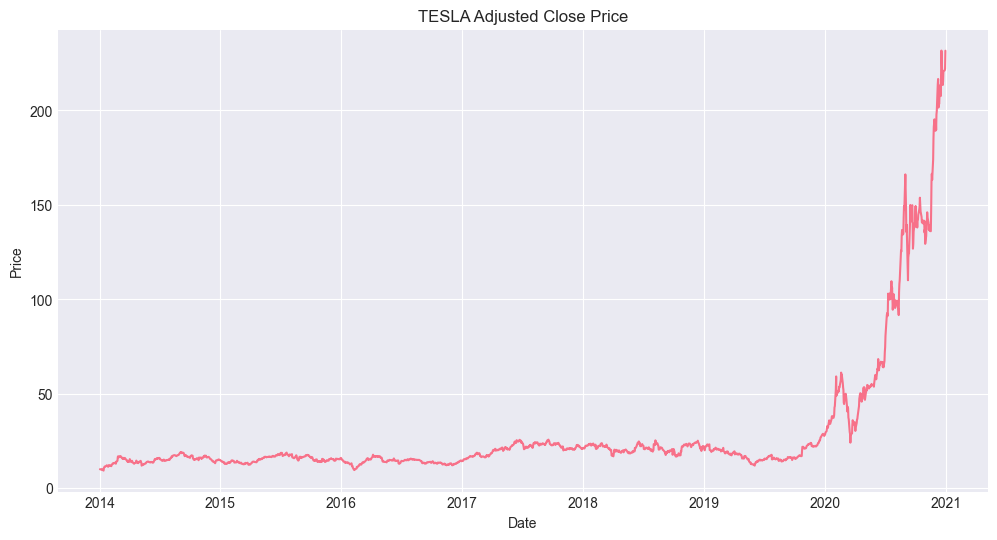

In [15]:
# Load data
dt = yf.download('TSLA', start='2014-01-01', end='2020-12-31')

# Get the adjusted close price for each trading day
tesla = dt['Close']
# tesla = dt['Close']["2016-01-02": "2018-12-31"]

plt.figure(figsize=(12, 6))
plt.plot(tesla)
plt.title('TESLA Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

The series is clearly non-stationary, so we will compute the log returns series.

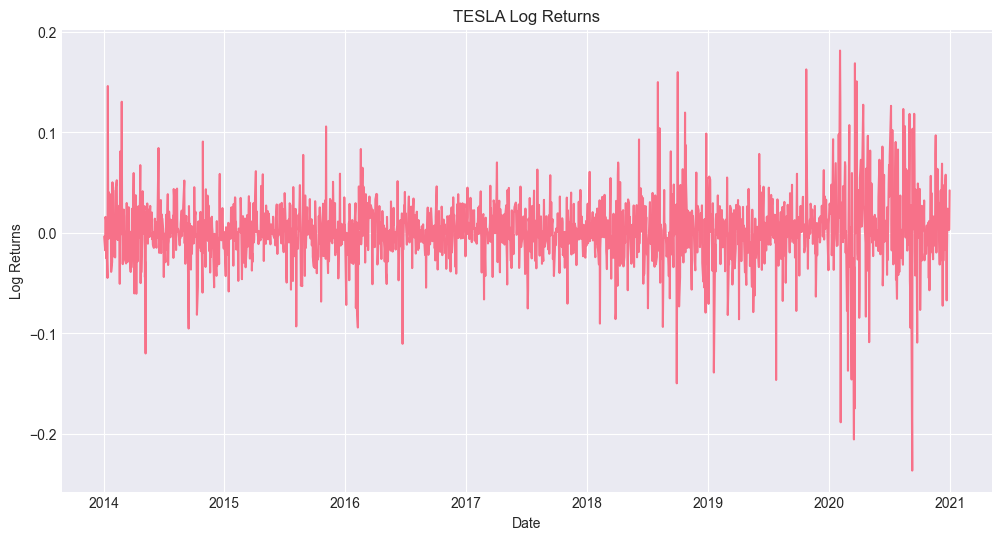

In [17]:
# Compute log returns
tesla_lr = np.log(tesla).diff()

plt.figure(figsize=(12, 6))
plt.plot(tesla_lr)
plt.title('TESLA Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.show()

The series shows no trend or seasonality, so we could try to fit a null model that only includes a constant.

In [18]:
# Fit ARIMA(0,0,0) - just a constant mean
tesla_lr_clean = tesla_lr.dropna()
fit_AR0 = ARIMA(tesla_lr_clean, order=(0, 0, 0)).fit()
print(fit_AR0.summary())

c:\Users\boyko\stats\ts2025\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\boyko\stats\ts2025\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\boyko\stats\ts2025\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 1761
Model:                          ARIMA   Log Likelihood                3452.090
Date:                Tue, 09 Dec 2025   AIC                          -6900.180
Time:                        22:08:21   BIC                          -6889.233
Sample:                             0   HQIC                         -6896.135
                               - 1761                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.189      0.029       0.000       0.003
sigma2         0.0012   1.92e-05     60.297      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.07   Jarque-

c:\Users\boyko\stats\ts2025\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Let's check the model fit with diagnostic plots:

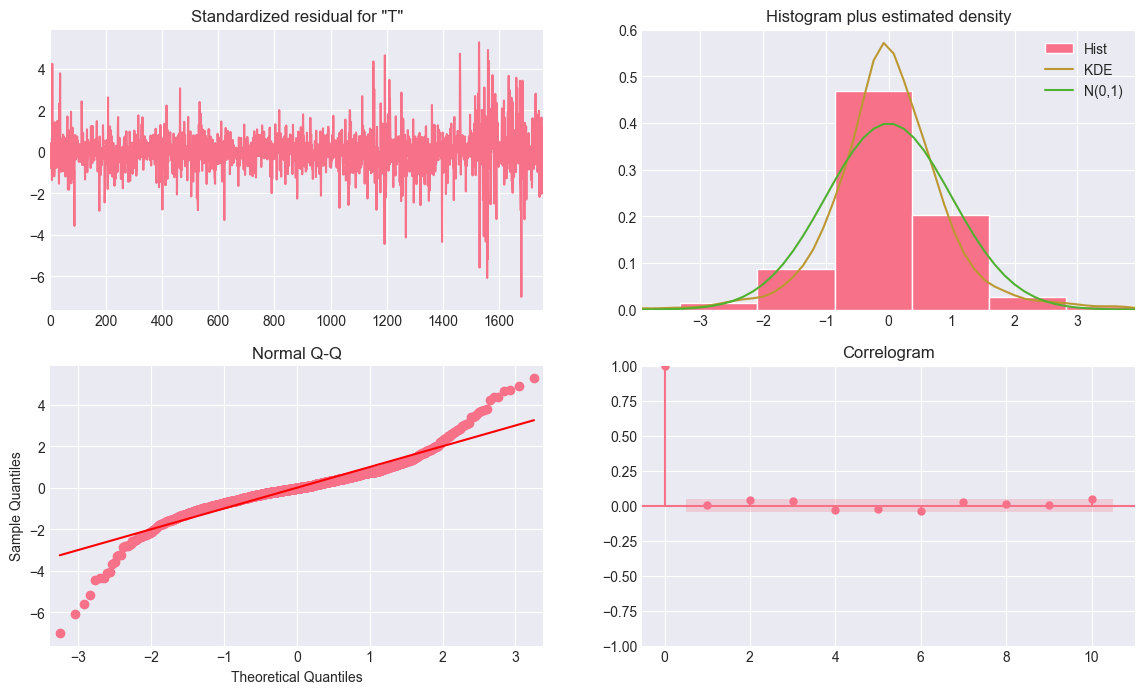

In [19]:
# Diagnostic plots
fit_AR0.plot_diagnostics(figsize=(14, 8))
plt.show()

We don't detect any deviations from the white noise assumptions in the diagnostic plots. However, we see long periods of high and low volatility in the standardized residuals plot. Let's check the ACF of the squared residuals. You can extract the residuals from the fitted model using the `resid` attribute.

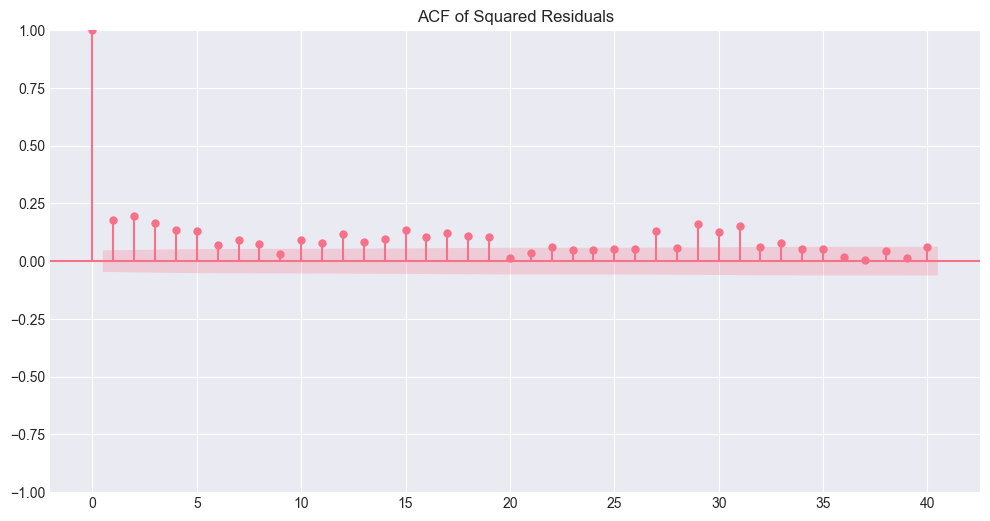

In [20]:
# Get residuals and plot ACF of squared residuals
fit_AR0_res = fit_AR0.resid

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(fit_AR0_res**2, lags=40, ax=ax)
ax.set_title('ACF of Squared Residuals')
plt.show()

We notice high autocorrelations in the squared residuals. This indicates that although the residual series appears uncorrelated, its second moment is not consistent with a pure white noise process. Look at the simulated series below to see how the squared residuals should look like if they resemble a white noise process:

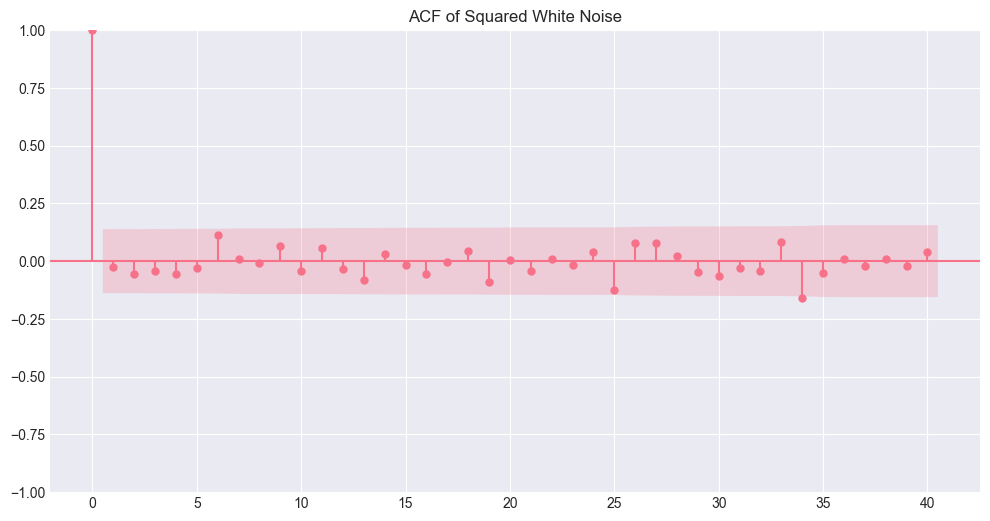

In [21]:
# Simulate white noise and check ACF of squared values
x = np.random.randn(200)

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(x**2, lags=40, ax=ax)
ax.set_title('ACF of Squared White Noise')
plt.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Generate data from t-distribution with heavy tails (df=3)
np.random.seed(42)
df = 3  # degrees of freedom - lower df = heavier tails
data = np.random.standard_t(df, size=1000)

# Compute theoretical quantiles (normal distribution)
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(data)))
sample_quantiles = np.sort(data)

# Create x range for density curves
x_range = np.linspace(data.min(), data.max(), 200)
normal_pdf = stats.norm.pdf(x_range, loc=data.mean(), scale=data.std())
t_pdf = stats.t.pdf(x_range, df=df, loc=data.mean(), scale=data.std())

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Data Distribution (t with df=3) - with Normal and t overlays',
        'QQ Plot: Sample vs Normal',
        'Histogram vs Normal Distribution',
        'Probability Plot'
    ),
    specs=[[{"type": "histogram"}, {"type": "scatter"}],
           [{"type": "histogram"}, {"type": "scatter"}]]
)

# 1. Histogram of data with normal and t-distribution overlays
fig.add_trace(
    go.Histogram(x=data, nbinsx=50, name='Data (t-distribution)',
                 marker_color='steelblue', opacity=0.5, histnorm='probability density'),
    row=1, col=1
)

# Overlay normal distribution
fig.add_trace(
    go.Scatter(x=x_range, y=normal_pdf,
               mode='lines', name='Normal Distribution',
               line=dict(color='red', width=3, dash='dash')),
    row=1, col=1
)

# Overlay t-distribution
fig.add_trace(
    go.Scatter(x=x_range, y=t_pdf,
               mode='lines', name=f't-distribution (df={df})',
               line=dict(color='green', width=3)),
    row=1, col=1
)

# 2. QQ Plot
fig.add_trace(
    go.Scatter(x=theoretical_quantiles, y=sample_quantiles,
               mode='markers', name='Sample quantiles',
               marker=dict(size=5, color='steelblue', opacity=0.6),
               hovertemplate='Theoretical: %{x:.2f}<br>Sample: %{y:.2f}<extra></extra>'),
    row=1, col=2
)

# Add perfect fit line (y=x)
min_val = min(theoretical_quantiles.min(), sample_quantiles.min())
max_val = max(theoretical_quantiles.max(), sample_quantiles.max())
fig.add_trace(
    go.Scatter(x=[min_val, max_val], y=[min_val, max_val],
               mode='lines', name='Perfect fit (y=x)',
               line=dict(color='red', dash='dash', width=2),
               showlegend=True),
    row=1, col=2
)

# 3. Histogram with normal distribution overlay
fig.add_trace(
    go.Histogram(x=data, nbinsx=50, name='Observed',
                 marker_color='steelblue', opacity=0.6, histnorm='probability density'),
    row=2, col=1
)

# Overlay normal distribution
fig.add_trace(
    go.Scatter(x=x_range, y=normal_pdf,
               mode='lines', name='Normal (red dashed)',
               line=dict(color='red', width=2, dash='dash')),
    row=2, col=1
)

# Overlay t-distribution
fig.add_trace(
    go.Scatter(x=x_range, y=t_pdf,
               mode='lines', name='t-dist (green solid)',
               line=dict(color='green', width=2)),
    row=2, col=1
)

# 4. Probability plot (empirical vs theoretical CDF)
empirical_cdf = np.arange(1, len(sample_quantiles) + 1) / len(sample_quantiles)
theoretical_cdf = stats.norm.cdf(sample_quantiles)

fig.add_trace(
    go.Scatter(x=theoretical_cdf, y=empirical_cdf,
               mode='markers', name='Empirical vs Theoretical CDF',
               marker=dict(size=5, color='steelblue', opacity=0.6),
               hovertemplate='Theoretical CDF: %{x:.2f}<br>Empirical CDF: %{y:.2f}<extra></extra>'),
    row=2, col=2
)

# Add perfect fit line
fig.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1],
               mode='lines', name='Perfect fit',
               line=dict(color='red', dash='dash', width=2),
               showlegend=False),
    row=2, col=2
)

# Update layout
fig.update_xaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Density", row=1, col=1)

fig.update_xaxes(title_text="Theoretical Quantiles (Normal)", row=1, col=2)
fig.update_yaxes(title_text="Sample Quantiles", row=1, col=2)

fig.update_xaxes(title_text="Value", row=2, col=1)
fig.update_yaxes(title_text="Density", row=2, col=1)

fig.update_xaxes(title_text="Theoretical CDF", row=2, col=2)
fig.update_yaxes(title_text="Empirical CDF", row=2, col=2)

fig.update_layout(
    title_text="QQ Plot Explanation: t-Distribution with Heavy Tails vs Normal Distribution",
    height=900,
    width=1200,
    showlegend=True,
    hovermode='closest'
)

fig.show()

# Print interpretation
print("=" * 70)
print("QQ PLOT INTERPRETATION: t-Distribution (df=3) vs Normal Distribution")
print("=" * 70)
print(f"\nData Summary:")
print(f"  Sample size: {len(data)}")
print(f"  Mean: {data.mean():.4f}")
print(f"  Std Dev: {data.std():.4f}")
print(f"  Skewness: {stats.skew(data):.4f}")
print(f"  Kurtosis (excess): {stats.kurtosis(data):.4f}")

print(f"\nNormal Distribution (for comparison):")
print(f"  Mean: 0.0000")
print(f"  Std Dev: 1.0000")
print(f"  Skewness: 0.0000")
print(f"  Kurtosis (excess): 0.0000")

print(f"\nt-Distribution (df={df}):")
print(f"  Expected Kurtosis: {stats.t.stats(df=df, moments='k'):.4f}")

print(f"\n** KEY OBSERVATIONS **")
print(f"1. TOP-LEFT: t-distribution (green) fits data better than normal (red dashed)")
print(f"2. The t-distribution has HEAVIER tails, capturing more extreme values")
print(f"3. TOP-RIGHT QQ Plot: Points deviate from diagonal in the TAILS")
print(f"   → Upper-right corner: data has MORE extreme values than normal predicts")
print(f"   → Lower-left corner: data has MORE extreme negative values")
print(f"4. This S-shaped pattern indicates HEAVY TAILS")
print(f"5. Typical of financial returns data (e.g., TESLA stock)")
print(f"6. Using a normal distribution UNDERESTIMATES tail risk!")
print("=" * 70)

QQ PLOT INTERPRETATION: t-Distribution (df=3) vs Normal Distribution

Data Summary:
  Sample size: 1000
  Mean: -0.0290
  Std Dev: 1.5184
  Skewness: -0.4862
  Kurtosis (excess): 6.7841

Normal Distribution (for comparison):
  Mean: 0.0000
  Std Dev: 1.0000
  Skewness: 0.0000
  Kurtosis (excess): 0.0000

t-Distribution (df=3):
  Expected Kurtosis: inf

** KEY OBSERVATIONS **
1. TOP-LEFT: t-distribution (green) fits data better than normal (red dashed)
2. The t-distribution has HEAVIER tails, capturing more extreme values
3. TOP-RIGHT QQ Plot: Points deviate from diagonal in the TAILS
   → Upper-right corner: data has MORE extreme values than normal predicts
   → Lower-left corner: data has MORE extreme negative values
4. This S-shaped pattern indicates HEAVY TAILS
5. Typical of financial returns data (e.g., TESLA stock)
6. Using a normal distribution UNDERESTIMATES tail risk!


We should also check the distribution of the residuals.

The reddish line is an empirical density estimate. The blueish line is a normal distribution with zero mean and a standard deviation equal to the estimated σ from the model fit. You can extract the estimated σ from the fit object: `fit_AR0.params['sigma2']`. Notice that the normal distribution has fewer mass at the tails than the empirical density estimate.

# ARCH models

The ARIMA models discussed so far assume that the residual process is uncorrelated and with a constant variance. The prediction interval that we introduced in the previous section relied on the assumption of normality of the error terms. However, it is common, especially in financial data to observe values of the time series that are more extreme than the normal distribution would accommodate. Another pattern that is commonly seen in financial data are volatility clusters: periods of high variance and periods of low variance.

For example, the simple stationary AR(1) model has constant unconditional variance:

$$
y_t = \phi_0 + \phi_1 y_{t - 1} + e_t, e_t \sim WN(\sigma^2)
$$

$$
Var(y_t) = \frac{\sigma^2}{1 - \phi_1^2}
$$

The conditional variance (defined analogously to the conditional mean) can be shown to equal:

$$
Var_{t - 1}(y_{t}) = E\left(y_t - E_{t - 1}y_t^2\right) = \sigma^2
$$

This is in contrast to the conditional mean, which is not constant but depends on the previous value of the process.

$$
E_{t - 1} y_t = \phi_0 + \phi_1 y_{t - 1}
$$

The idea of the ARCH models is to let the conditional variance depend on lagged values of the error term:

$$
h^2_t = Var_{t - 1}(e_t) = E_{t - 1}(e^2_t)
$$

The ARCH(q) model uses q lags of the squared error terms to model the conditional variance

$$
h_{t}^2 = \omega + \alpha_1 e^2_{t - 1} + \alpha_2 e^2_{t - 2} + \ldots + \alpha_q e^2_{t - q}
$$

To understand the correlation that is induced between the conditional variances, write the above equation for $t + 1$:

$$
h_{t + 1}^2 = \omega + \alpha_1 e^2_{t} + \alpha_2 e^2_{t - 1} + \ldots + \alpha_q e^2_{t - q + 1}
$$


To ensure that the conditional variance is positive, the coefficients must all be non-negative and $\alpha_q > 0$.

Because the conditional volatility depends on the past values of the shocks, a large shock will tend to produce a high conditional variance that will dissipate only slowly. Small shocks will tend to produce a low conditional variance. The length of the volatility clusters is determined by $q$.

Large values of $q$ can lead to estimation difficulties, however, so a more parsimonious model may be needed to deal with long volatility clusters. The GARCH(q, p) model extends the ARCH model by including lagged values of the conditional variance:

$$
h^2_t = \omega + \alpha_1 e^2_{1 - 1} + \alpha_2 e^2_{1 - 2} + \ldots + \alpha_q e^2_{t - q} + \beta_1 h^2_{t - 1} + \ldots + \beta_p h^2_{t - p}
$$

It is easy to show that under the GARCH(q, p) model the squared error terms $e^2_t$ is an ARMA process.

## GARCH(1, 1)

The GARCH(1, 1) model is sufficient for most cases of financial data

$$
h^2_t = \omega + \alpha e^2_{t - 1} + \beta h^2_{t - 1}, \quad \omega, \alpha, \beta > 0
$$

# Example (continued)

Let us fit a GARCH(1, 1) model to the TESLA data. We will use the `arch` package which is the Python equivalent of R's `rugarch`. The `arch_model` function allows us to specify both the mean model and the variance model. The GJR-GARCH model is an extension of GARCH that allows for asymmetric effects of positive and negative shocks.

In [39]:
# Fit GJR-GARCH(1,1) model with constant mean
# Convert returns to percentage (multiply by 100) for better numerical stability
tesla_lr_pct = tesla_lr_clean * 100

# Specify GJR-GARCH(1,1) model
# mean='Constant' corresponds to ARMA(0,0) with constant (include.mean=TRUE)
# vol='GARCH' with p=1, q=1 gives GARCH(1,1)
# o=0 suppresses the asymmetric term (GJR-GARCH)
# dist='normal' uses normal distribution
model = arch_model(tesla_lr_pct, mean='Constant', vol='GARCH', p=1, q=1, o=0, dist='t')
fit_GARCH11 = model.fit(disp='off')
print(fit_GARCH11.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         TSLA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4369.05
Distribution:      Standardized Student's t   AIC:                           8748.11
Method:                  Maximum Likelihood   BIC:                           8775.47
                                              No. Observations:                 1761
Date:                      Tue, Dec 09 2025   Df Residuals:                     1760
Time:                              23:05:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

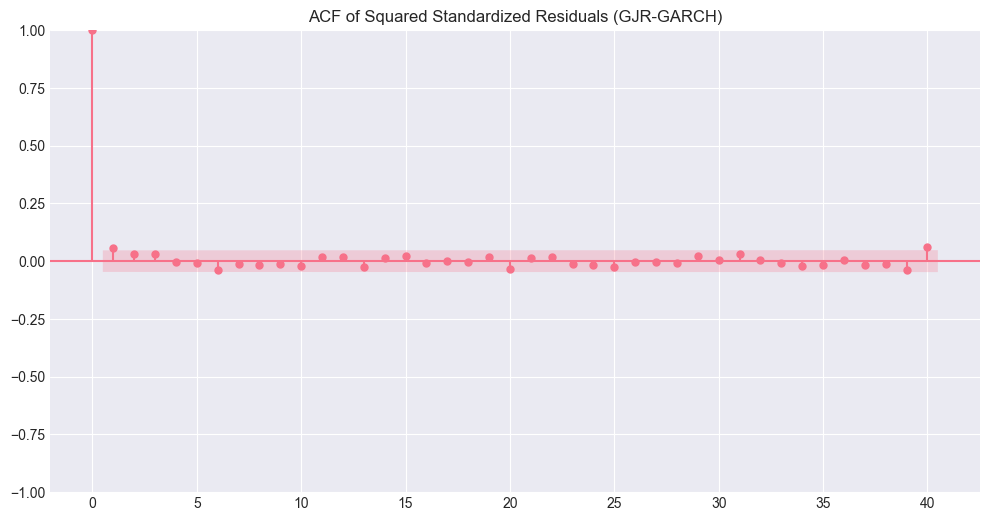

In [ ]:
# Get standardized residuals
fit_GARCH11_res = fit_GARCH11.std_resid

# Plot ACF of squared standardized residuals
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(fit_GARCH11_res**2, lags=40, ax=ax)
ax.set_title('ACF of Squared Standardized Residuals (GARCH)')
plt.show()

You can find a nice guide to the `arch` package [here](https://arch.readthedocs.io/en/latest/).

## Forecasting

In [34]:
# Forecast 10 steps ahead
forecast = fit_GARCH11.forecast(horizon=3)

print("Mean forecast:")
print(forecast.mean.iloc[-1])

print("\nVariance forecast:")
print(forecast.variance.iloc[-1])

print("\nResidual variance forecast:")
print(forecast.residual_variance.iloc[-1])

Mean forecast:
h.1    0.097161
h.2    0.097161
h.3    0.097161
Name: 2020-12-30 00:00:00, dtype: float64

Variance forecast:
h.1    16.246367
h.2    16.216575
h.3    16.186956
Name: 2020-12-30 00:00:00, dtype: float64

Residual variance forecast:
h.1    16.246367
h.2    16.216575
h.3    16.186956
Name: 2020-12-30 00:00:00, dtype: float64


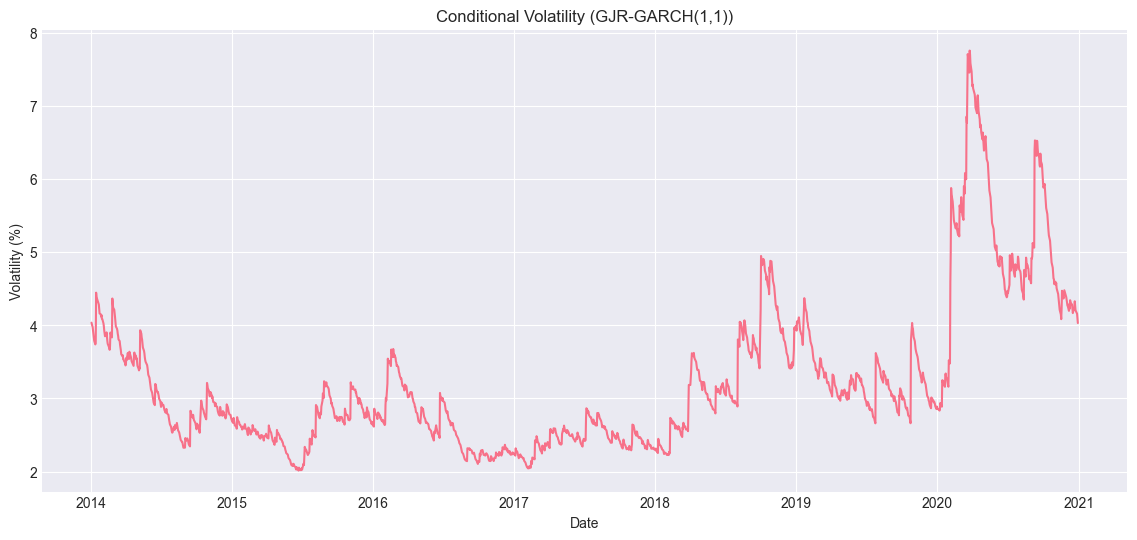

In [35]:
# Plot conditional volatility
plt.figure(figsize=(14, 6))
plt.plot(fit_GARCH11.conditional_volatility)
plt.title('Conditional Volatility (GJR-GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.show()